In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
# Load data
dfcp = pd.read_csv('/Users/mohankarthikv/Downloads/School Performance Data Collection-Project.csv')

# Data cleaning and preprocessing
dfcp = dfcp.drop(["Free lunch Not Eligible"], axis=1)
dfcp = dfcp.dropna()

# Removing duplicates
dfcp.drop_duplicates(subset=['School Name', 'Zip Code'], keep='first', inplace=True)

# Replace non-numeric characters in specified columns
dfcp['Math Score'] = dfcp['Math Score'].str.replace('%', '').astype(float) / 100
dfcp['English Score'] = dfcp['English Score'].str.replace('%', '').astype(float) / 100
dfcp['Graduation Rate'] = dfcp['Graduation Rate'].str.replace('%', '').astype(float) / 100

# Define high-performing schools based on median scores for English, Math, and Graduation Rate
medians = dfcp[['English Score', 'Math Score', 'Graduation Rate']].median()
dfcp['High_Performing'] = ((dfcp['English Score'] > medians['English Score']) &
                           (dfcp['Math Score'] > medians['Math Score']) &
                           (dfcp['Graduation Rate'] > medians['Graduation Rate'])).astype(int)

In [4]:
# Encode categorical data
categorical_columns = dfcp.select_dtypes(include=['object']).columns.tolist()
for column in categorical_columns:
    dfcp[column] = LabelEncoder().fit_transform(dfcp[column])

# Prepare features and target
X = dfcp.drop(['High_Performing'], axis=1)
y = dfcp['High_Performing']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize a Random Forest Classifier
classifier = RandomForestClassifier(random_state=42)

# Perform K-Fold Cross Validation with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_scaled, y)
best_classifier = grid_search.best_estimator_


In [5]:
# Perform K-Fold Cross Validation with the best estimator
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = cross_val_score(best_classifier, X_scaled, y, cv=kf, scoring='accuracy')
cv_precision = cross_val_score(best_classifier, X_scaled, y, cv=kf, scoring='precision')
cv_recall = cross_val_score(best_classifier, X_scaled, y, cv=kf, scoring='recall')
cv_f1 = cross_val_score(best_classifier, X_scaled, y, cv=kf, scoring='f1')

# Print cross-validated metrics
print("Cross-validated Metrics:")
print(f"Accuracy: {cv_accuracy.mean():.2f}")
print(f"Precision: {cv_precision.mean():.2f}")
print(f"Recall: {cv_recall.mean():.2f}")
print(f"F1-score: {cv_f1.mean():.2f}")

Cross-validated Metrics:
Accuracy: 0.91
Precision: 0.90
Recall: 0.71
F1-score: 0.73


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model on the training set
best_classifier.fit(X_train, y_train)

# Predict on the test set
predictions = best_classifier.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

# Print model accuracy and classification report
print("\nEvaluation on Test Set:")
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)


Evaluation on Test Set:
Model Accuracy: 94.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.75      0.86         4

    accuracy                           0.94        17
   macro avg       0.96      0.88      0.91        17
weighted avg       0.95      0.94      0.94        17



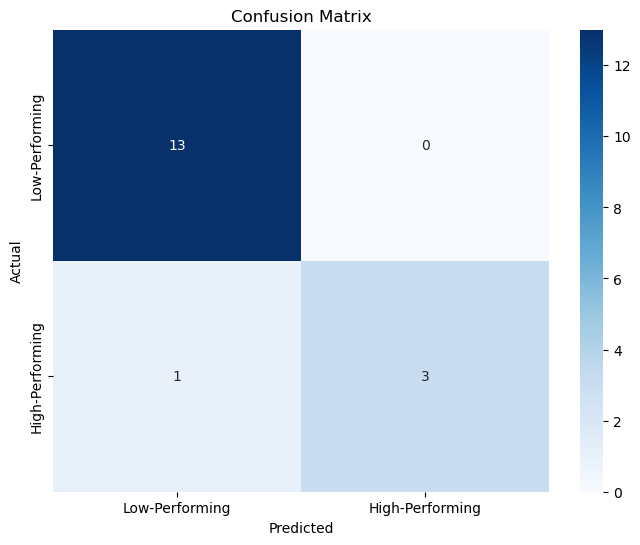

In [8]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low-Performing', 'High-Performing'], yticklabels=['Low-Performing', 'High-Performing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

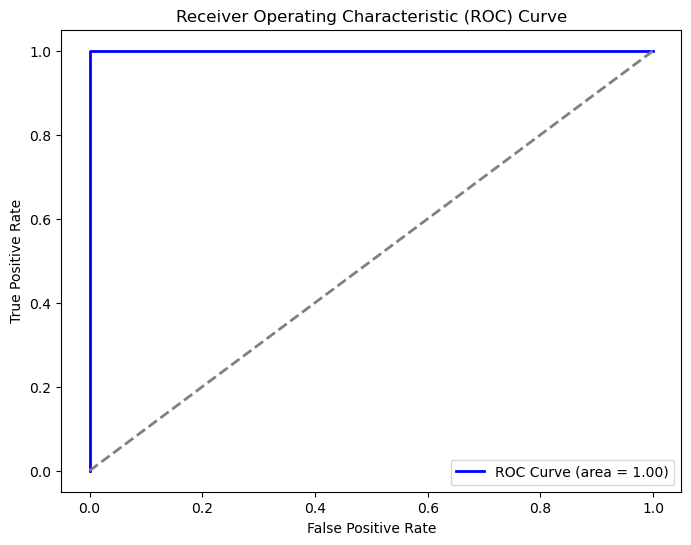

In [9]:
# ROC Curve
y_test_prob = best_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [11]:
# Predict on the entire dataset
dfcp['Predicted_Performance'] = best_classifier.predict(X_scaled)

# Map predicted labels back to 'High-Performing' or 'Low-Performing'
dfcp['Performance_Label'] = dfcp['Predicted_Performance'].map({1: 'High-Performing', 0: 'Low-Performing'})

# Output the DataFrame with the new predictions and their labels
print("\nPredictions on Entire Dataset:")
print(dfcp[['School Name', 'Math Score', 'English Score', 'Graduation Rate', 'Performance_Label']])

# Save the results to an Excel file
excel_path = '/Users/mohankarthikv/Downloads/School_Performance_Predictions_random_forest.xlsx'
dfcp.to_excel(excel_path, index=False)


Predictions on Entire Dataset:
     School Name  Math Score  English Score  Graduation Rate Performance_Label
0             14        0.45           0.48             0.94   High-Performing
3              1        0.24           0.37             0.94    Low-Performing
4             34        0.15           0.15             0.22    Low-Performing
5             49        0.13           0.20             0.92    Low-Performing
9             80        0.13           0.23             0.87    Low-Performing
..           ...         ...            ...              ...               ...
166           64        0.08           0.12             0.75    Low-Performing
167           65        0.27           0.37             0.10    Low-Performing
169           68        0.18           0.32             0.34    Low-Performing
170           69        0.18           0.27             0.20    Low-Performing
171           70        0.58           0.52             0.62    Low-Performing

[85 rows x 5 column